#### STEP 1: Load & Sample Data (Spark → Pandas)

In [0]:
#Load gold features
ml_features = spark.table("gold.ml_features")

# Sample to fit Pandas memory
df_sampled = ml_features.sample(fraction=0.001, seed=42)

#Drop nulls
df_sampled = df_sampled.dropna()

#Convert to Pandas
df_ml = df_sampled.toPandas()

#Split features / label
X = df_ml.drop("label", axis=1)
y = df_ml["label"]

print("Rows:", len(df_ml))
print("Label distribution:\n", y.value_counts())

Rows: 109010
Label distribution:
 label
0    107340
1      1670
Name: count, dtype: int64


#### STEP 2: Train / Test Split (Stratified)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train Lables:", y_train.value_counts().to_dict())
print("Test Lables:", y_test.value_counts().to_dict())

Train Lables: {0: 85872, 1: 1336}
Test Lables: {0: 21468, 1: 334}


#### STEP 3:Setup MLflow Experiment

In [0]:
import mlflow
mlflow.set_experiment("/Shared/day13_model_comparison")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/257983312861070', creation_time=1768939990182, experiment_id='257983312861070', last_update_time=1768968985875, lifecycle_stage='active', name='/Shared/day13_model_comparison', tags={'mlflow.experiment.sourceName': '/Shared/day13_model_comparison',
 'mlflow.experimentKind': 'custom_model_development',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'vidyarasu@gmail.com',
 'mlflow.ownerId': '76030603077274'}>

#### STEP 4: Baseline Model (Logistic Regression)

In [0]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix

#Start MLflow experiment
mlflow.set_experiment("/Shared/day12_purchase_prediction")

with mlflow.start_run(run_name="logistic_regression_v1"):
    # Log parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)

    #Train the model
    model = LogisticRegression(max_iter=200, class_weight="balanced") #class_weight balances for imbalance
    model.fit(X_train, y_train)

    #Predict on test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    #Compute metrics
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("roc_auc", roc)

    #Optional: log confusion matrix as artifact
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    #Log the model
    mlflow.sklearn.log_model(model, artifact_path="model")

print(f"Run finished. Accuracy: {acc:.4f}, ROC AUC: {roc:.4f}")

Confusion Matrix:
 [[11778  9690]
 [  149   185]]


2026/01/21 11:59:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run finished. Accuracy: 0.5487, ROC AUC: 0.5769


#### Step 5: Random Forest 

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from mlflow.models import infer_signature

mlflow.set_experiment("/Shared/day13_model_comparison")

with mlflow.start_run(run_name="random_forest"):

    # 1. Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        class_weight="balanced",
        random_state=42
    )
    rf.fit(X_train, y_train)

    # 2. Predictions
    y_proba = rf.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    # 3. Compute metrics
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc:.4f}, ROC-AUC: {roc:.4f}, F1: {f1:.4f}")

    # 4. Create input example (first 5 rows of X_train)
    input_example = X_train.iloc[:5]

    # 5. Infer signature (using predict_proba)
    signature = infer_signature(input_example, rf.predict_proba(input_example))

    # 6. Log parameters, metrics, model
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 5)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("roc_auc", roc)
    mlflow.log_metric("f1", f1)

    mlflow.sklearn.log_model(
        rf,
        artifact_path="model",
        signature=signature,
        input_example=input_example
    )

Confusion Matrix:
 [[12515  8953]
 [  132   202]]
Accuracy: 0.5833, ROC-AUC: 0.6394, F1: 0.0426


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


#### Step 6: Gradient Boosting

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from mlflow.models import infer_signature
import mlflow
import mlflow.sklearn

# Set MLflow experiment
mlflow.set_experiment("/Shared/day13_model_comparison")

# Step 1: Initialize Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=400, 
    max_depth=10, 
    learning_rate=0.2, 
    random_state=42
)

# Step 2: Fit model
gb.fit(X_train, y_train)

# Step 3: Predict probabilities
y_proba = gb.predict_proba(X_test)[:, 1]

# Step 4: Threshold tuning
thresholds = [0.1,0.2,0.3, 0.4, 0.5]
best_f1 = -1
best_threshold = 0.5
best_metrics = {}

for t in thresholds:
    y_pred = (y_proba > t).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
        best_metrics = {
            "accuracy": acc,
            "roc_auc": roc,
            "f1": f1,
            "confusion_matrix": cm
        }

print(f"Best threshold: {best_threshold}")
print(f"Accuracy: {best_metrics['accuracy']:.4f}, ROC-AUC: {best_metrics['roc_auc']:.4f}, F1: {best_metrics['f1']:.4f}")
print("Confusion Matrix:")
print(best_metrics['confusion_matrix'])

# Step 5: Log to MLflow
input_example = X_train.iloc[:5]
signature = infer_signature(input_example, gb.predict(input_example))

with mlflow.start_run(run_name="gradient_boosting"):
    # Log parameters
    mlflow.log_param("n_estimators", 400)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("learning_rate", 0.2)
    mlflow.log_param("best_threshold", best_threshold)
    
    # Log metrics
    mlflow.log_metric("accuracy", best_metrics['accuracy'])
    mlflow.log_metric("roc_auc", best_metrics['roc_auc'])
    mlflow.log_metric("f1", best_metrics['f1'])
    
    # Log model
    mlflow.sklearn.log_model(
        gb,
        artifact_path="model",
        signature=signature,
        input_example=input_example
    )

Best threshold: 0.2
Accuracy: 0.9757, ROC-AUC: 0.6287, F1: 0.0364
Confusion Matrix:
[[21263   205]
 [  324    10]]


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


#### Feature Importance

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def log_feature_importance(model, model_name, X_train):
    if hasattr(model, "feature_importances_"):  # Random Forest, Gradient Boosting
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):  # Logistic Regression
        importances = abs(model.coef_[0])
    else:
        print(f"No feature importance available for {model_name}")
        return
    
    fi_df = pd.DataFrame({
        "feature": X_train.columns,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    print(f"Feature Importance for {model_name}:\n", fi_df)

    # Optional: plot
    plt.figure(figsize=(8,6))
    sns.barplot(x="importance", y="feature", data=fi_df)
    plt.title(f"{model_name} Feature Importance")
    plt.show()

    # Log feature importance as MLflow artifact
    fi_file = f"/tmp/{model_name}_feature_importance.csv"
    fi_df.to_csv(fi_file, index=False)
    mlflow.log_artifact(fi_file, artifact_path=f"{model_name}_feature_importance")


INFO:matplotlib.font_manager:generated new fontManager


Logistic Regression Confusion Matrix:
 [[11778  9690]
 [  149   185]]
Accuracy: 0.5487, ROC-AUC: 0.5769, F1: 0.0362


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Feature Importance for LogisticRegression:
                   feature    importance
0               price_log  1.263361e-01
2             day_of_week  6.918881e-02
3              is_weekend  2.706510e-02
1                    hour  2.682043e-02
4  time_since_first_event  7.423177e-08


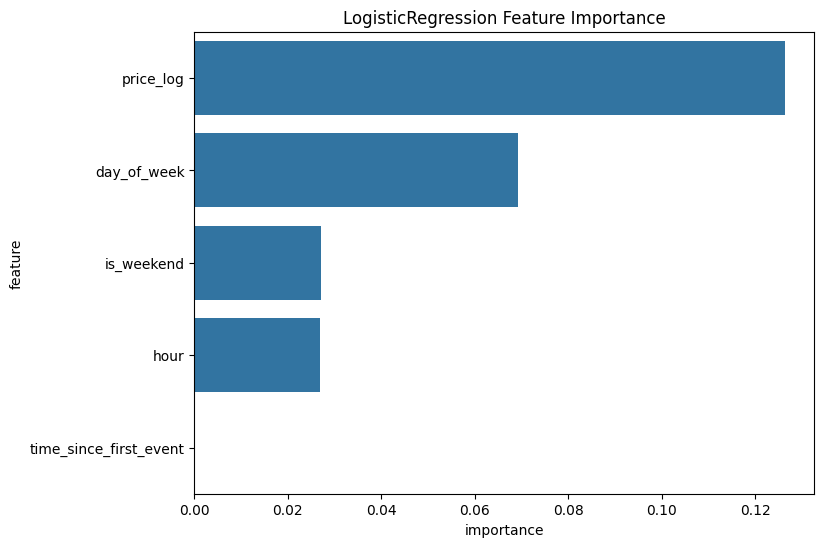

Random Forest Confusion Matrix:
 [[12515  8953]
 [  132   202]]
Accuracy: 0.5833, ROC-AUC: 0.6394, F1: 0.0426


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Feature Importance for RandomForest:
                   feature  importance
4  time_since_first_event    0.485513
1                    hour    0.194472
0               price_log    0.185041
2             day_of_week    0.125382
3              is_weekend    0.009593


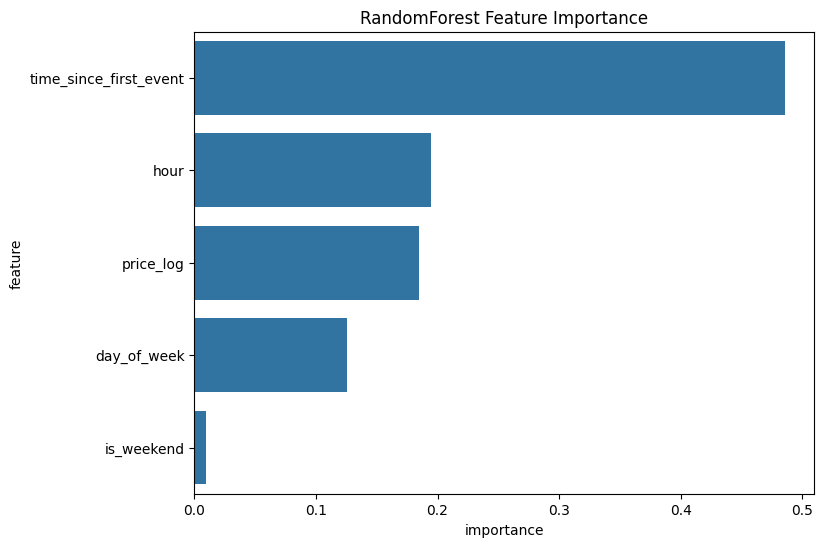

Gradient Boosting Best Threshold: 0.2
Accuracy: 0.9757, ROC-AUC: 0.6287, F1: 0.0364
Confusion Matrix:
 [[21263   205]
 [  324    10]]


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Feature Importance for GradientBoosting:
                   feature  importance
4  time_since_first_event    0.539381
0               price_log    0.290192
1                    hour    0.102149
2             day_of_week    0.056311
3              is_weekend    0.011967


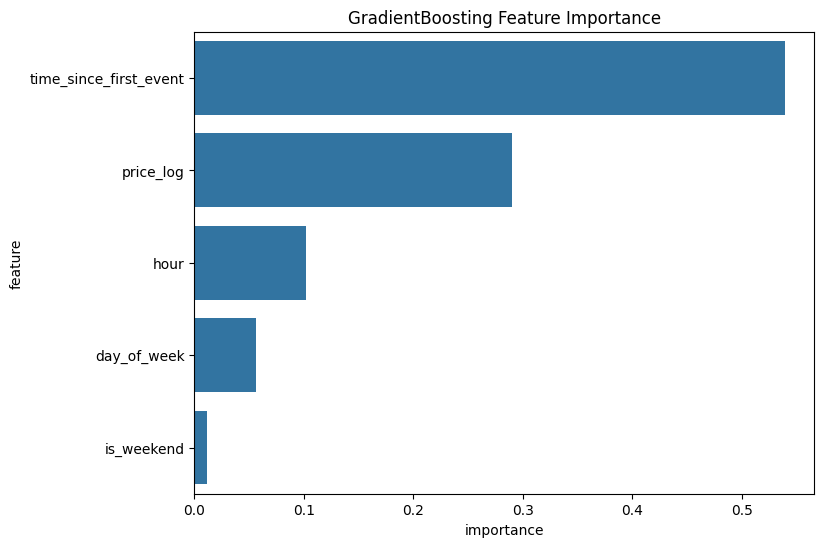

✅ Day 13: All models logged to MLflow. Compare metrics and confusion matrices in the UI.


In [0]:
# ============================
# Day 13: Model Comparison
# ============================

import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from mlflow.models import infer_signature

# ----------------------------
# 1. Set MLflow Experiment
# ----------------------------
mlflow.set_experiment("/Shared/day13_model_comparison")

# ----------------------------
# 2. Prepare input example
# ----------------------------
input_example = X_train.iloc[:5]  # first 5 rows

# ----------------------------
# 3. Logistic Regression Run
# ----------------------------
with mlflow.start_run(run_name="logistic_regression"):

    lr = LogisticRegression(max_iter=200, class_weight="balanced", random_state=42)
    lr.fit(X_train, y_train)
    
    y_proba = lr.predict_proba(X_test)[:,1]
    y_pred = (y_proba > 0.5).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print("Logistic Regression Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc:.4f}, ROC-AUC: {roc:.4f}, F1: {f1:.4f}")
    
    signature = infer_signature(input_example, lr.predict_proba(input_example))
    
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("roc_auc", roc)
    mlflow.log_metric("f1", f1)
    
    mlflow.sklearn.log_model(lr, artifact_path="model", signature=signature, input_example=input_example)
    log_feature_importance(lr, "LogisticRegression", X_train)


# ----------------------------
# 4. Random Forest Run
# ----------------------------
with mlflow.start_run(run_name="random_forest"):

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        class_weight="balanced",
        random_state=42
    )
    rf.fit(X_train, y_train)
    
    y_proba = rf.predict_proba(X_test)[:,1]
    y_pred = (y_proba > 0.5).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print("Random Forest Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc:.4f}, ROC-AUC: {roc:.4f}, F1: {f1:.4f}")
    
    signature = infer_signature(input_example, rf.predict_proba(input_example))
    
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 5)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("roc_auc", roc)
    mlflow.log_metric("f1", f1)
    
    mlflow.sklearn.log_model(rf, artifact_path="model", signature=signature, input_example=input_example)
    log_feature_importance(rf, "RandomForest", X_train)


# ----------------------------
# 5. Gradient Boosting Run (Threshold Tuning)
# ----------------------------
with mlflow.start_run(run_name="gradient_boosting"):

    gb = GradientBoostingClassifier(
        n_estimators=400,
        max_depth=10,
        learning_rate=0.2,
        random_state=42
    )
    gb.fit(X_train, y_train)
    
    y_proba = gb.predict_proba(X_test)[:,1]
    
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
    best_f1 = -1
    best_threshold = 0.5
    best_metrics = {}
    
    for t in thresholds:
        y_pred = (y_proba > t).astype(int)
        acc = accuracy_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
            best_metrics = {"accuracy": acc, "roc_auc": roc, "f1": f1, "confusion_matrix": cm}
    
    print(f"Gradient Boosting Best Threshold: {best_threshold}")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}, ROC-AUC: {best_metrics['roc_auc']:.4f}, F1: {best_metrics['f1']:.4f}")
    print("Confusion Matrix:\n", best_metrics['confusion_matrix'])
    
    signature = infer_signature(input_example, gb.predict(input_example))
    
    mlflow.log_param("model_type", "GradientBoosting")
    mlflow.log_param("n_estimators", 400)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("learning_rate", 0.2)
    mlflow.log_param("best_threshold", best_threshold)
    
    mlflow.log_metric("accuracy", best_metrics['accuracy'])
    mlflow.log_metric("roc_auc", best_metrics['roc_auc'])
    mlflow.log_metric("f1", best_metrics['f1'])
    
    mlflow.sklearn.log_model(gb, artifact_path="model", signature=signature, input_example=input_example)
    log_feature_importance(gb, "GradientBoosting", X_train)


# ----------------------------
# 6. Summary
# ----------------------------
print("✅ Day 13: All models logged to MLflow. Compare metrics and confusion matrices in the UI.")


In [0]:
# Summary of model comparison - Day 13
print("""
Day 13 Model Comparison Summary:
- Random Forest (n_estimators=200, max_depth=5, class_weight='balanced') achieved the highest ROC-AUC (~0.64) and best F1 (~0.042).
- Gradient Boosting shows higher accuracy but lower F1 and ROC-AUC.
- Logistic Regression underperformed on all metrics.

Next Steps:
- Focus on improving F1 score, possibly by threshold tuning or alternative imbalance handling.
- Register the best model (Random Forest) in MLflow Model Registry for deployment/testing.
""")

# Register best model using the actual Random Forest run ID
import mlflow

best_run_id = "cfb087ddaa814d61a3f27fa8488f0cc6"  # Random Forest run
model_name = "purchase_prediction_random_forest"

# Register the model
result = mlflow.register_model(
    model_uri=f"runs:/{best_run_id}/model",
    name=model_name
)

print(f"Model registered with name: {model_name}, version: {result.version}")



Day 13 Model Comparison Summary:
- Random Forest (n_estimators=200, max_depth=5, class_weight='balanced') achieved the highest ROC-AUC (~0.64) and best F1 (~0.042).
- Gradient Boosting shows higher accuracy but lower F1 and ROC-AUC.
- Logistic Regression underperformed on all metrics.

Next Steps:
- Focus on improving F1 score, possibly by threshold tuning or alternative imbalance handling.
- Register the best model (Random Forest) in MLflow Model Registry for deployment/testing.



Registered model 'purchase_prediction_random_forest' already exists. Creating a new version of this model...


Model registered with name: purchase_prediction_random_forest, version: 4


Created version '4' of model 'workspace.default.purchase_prediction_random_forest'.
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection


#### SPARK ML Pipeline

In [0]:
#STEP 1.1: Load the data in Spark
spark_df = spark.table("gold.ml_features").dropna()

#STEP 1.2: Inspect columns
spark_df.printSchema()

#STEP 1.3: Peek at rows
spark_df.show(5)

root
 |-- price_log: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- time_since_first_event: long (nullable = true)
 |-- label: integer (nullable = true)

+-----------------+----+-----------+----------+----------------------+-----+
|        price_log|hour|day_of_week|is_weekend|time_since_first_event|label|
+-----------------+----+-----------+----------+----------------------+-----+
|4.939998214496815|   8|          5|         0|                     0|    0|
|4.939998214496815|   3|          2|         0|                329424|    0|
|4.760976637126291|   2|          4|         0|                     0|    0|
|4.760976637126291|   2|          4|         0|                    50|    0|
|4.760976637126291|   6|          4|         0|                 15954|    0|
+-----------------+----+-----------+----------+----------------------+-----+
only showing top 5 rows


In [0]:
#STEP 2: Define feature columns 
feature_cols=['price_log', 'hour', 'day_of_week', 'is_weekend','time_since_first_event']
print(feature_cols)

['price_log', 'hour', 'day_of_week', 'is_weekend', 'time_since_first_event']


In [0]:
#STEP 3: Create the VectorAssembler (features → vector)
#STEP 3.1: Create the VectorAssembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

#STEP 3.2: Apply the assembler (transform)
assembled_df =  assembler.transform(spark_df)

#STEP 3.3: Inspect result
assembled_df.select("features", "label").show(5, truncate=False)

+----------------------------------------+-----+
|features                                |label|
+----------------------------------------+-----+
|[4.939998214496815,8.0,5.0,0.0,0.0]     |0    |
|[4.939998214496815,3.0,2.0,0.0,329424.0]|0    |
|[4.760976637126291,2.0,4.0,0.0,0.0]     |0    |
|[4.760976637126291,2.0,4.0,0.0,50.0]    |0    |
|[4.760976637126291,6.0,4.0,0.0,15954.0] |0    |
+----------------------------------------+-----+
only showing top 5 rows


In [0]:

#STEP 4: Sample the Spark data to avoid timeout
sampled_df = assembled_df.sample(fraction=0.001, seed=42)
print("Sampled Spark Data Rows:", sampled_df.count())

#STEP 4.1: Split the assembled data
train_df, test_df = sampled_df.randomSplit(
    [0.8,0.2],
    seed=42
)
#STEP 4.2: Verify row counts
print("Train rows:", train_df.count())
print("Test rows:", test_df.count())

train_df.select("features", "label").show(3, truncate=False)
test_df.select("features", "label").show(3, truncate=False)

INFO:py4j.clientserver:Received command c on object id p0


Sampled Spark Data Rows: 109010
Train rows: 88200
Test rows: 21741
+-------------------------------------------+-----+
|features                                   |label|
+-------------------------------------------+-----+
|[0.41871033485818504,18.0,6.0,0.0,25621.0] |0    |
|[0.6729444732424258,19.0,7.0,1.0,1309212.0]|0    |
|[0.9631743177730056,6.0,6.0,0.0,77814.0]   |0    |
+-------------------------------------------+-----+
only showing top 3 rows
+-------------------------------------------+-----+
|features                                   |label|
+-------------------------------------------+-----+
|[0.9400072584914712,10.0,4.0,0.0,3004978.0]|0    |
|[1.1969481893889715,16.0,2.0,0.0,0.0]      |0    |
|[1.2809338454620642,14.0,2.0,0.0,367085.0] |0    |
+-------------------------------------------+-----+
only showing top 3 rows


In [0]:
#STEP 5: Train ONE Spark ML model (Random Forest)
# STEP 5.1: Train Random Forest on sampled Spark data
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=50,    # smaller number for faster training
    maxDepth=5,
    seed=42
)
rf_model = rf.fit(train_df)

INFO:py4j.clientserver:Received command c on object id p0


INFO:py4j.clientserver:Received command c on object id p0


Feature Importance for Spark Random Forest:
                   feature  importance
4  time_since_first_event    0.855587
2             day_of_week    0.122759
1                    hour    0.021654
0               price_log    0.000000
3              is_weekend    0.000000


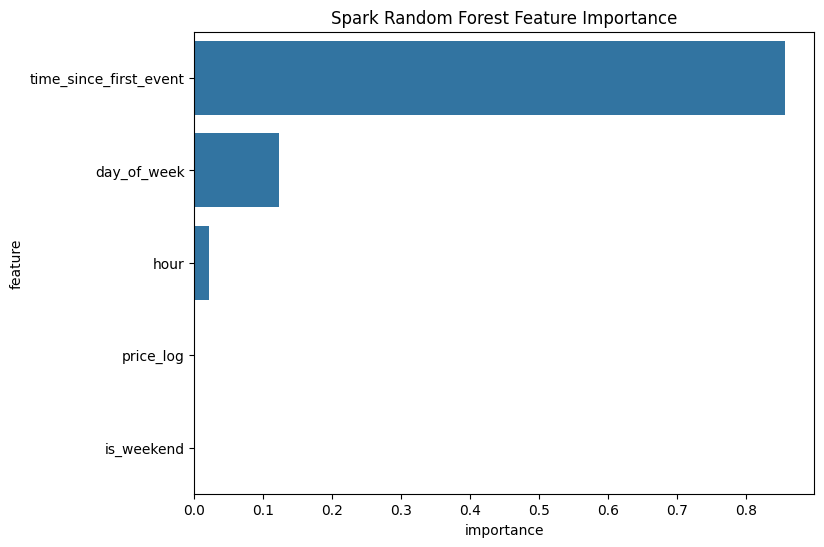

In [0]:
# STEP 5.2: Feature Importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract importances and feature names
importances = rf_model.featureImportances.toArray()
fi_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Print
print("Feature Importance for Spark Random Forest:\n", fi_df)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=fi_df)
plt.title("Spark Random Forest Feature Importance")
plt.show()


In [0]:
import os
os.environ["MLFLOW_DFS_TMP"] = "/Volumes/workspace/default/mlflow_tmp"

In [0]:
# STEP 7: Make predictions
preds = rf_model.transform(test_df)
preds.select("features", "label", "prediction", "probability").show(5, truncate=False)

+-------------------------------------------+-----+----------+-----------------------------------------+
|features                                   |label|prediction|probability                              |
+-------------------------------------------+-----+----------+-----------------------------------------+
|[0.9400072584914712,10.0,4.0,0.0,3004978.0]|0    |0.0       |[0.9850185226418995,0.014981477358100506]|
|[1.1969481893889715,16.0,2.0,0.0,0.0]      |0    |0.0       |[0.9850185226418995,0.014981477358100506]|
|[1.2809338454620642,14.0,2.0,0.0,367085.0] |0    |0.0       |[0.9850185226418995,0.014981477358100506]|
|[1.3506671834767394,18.0,2.0,0.0,4253644.0]|0    |0.0       |[0.9850185226418995,0.014981477358100506]|
|[1.4085449700547104,2.0,4.0,0.0,110783.0]  |0    |0.0       |[0.9850185226418995,0.014981477358100506]|
+-------------------------------------------+-----+----------+-----------------------------------------+
only showing top 5 rows


In [0]:
# STEP 8: Evaluate model
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

roc_auc = evaluator.evaluate(preds)
print(f"Sampled Spark Random Forest ROC AUC: {roc_auc:.4f}")

#Multiclass evaluator for Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator_acc.evaluate(preds)
print(f"Sampled Spark Random Forest Accuracy: {accuracy:.4f}")

# F1 score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
f1 = evaluator_f1.evaluate(preds)
print(f"Sampled Spark Random Forest F1: {f1:.4f}")

Sampled Spark Random Forest ROC AUC: 0.5461
Sampled Spark Random Forest Accuracy: 0.9856
Sampled Spark Random Forest F1: 0.9785


In [0]:
import mlflow
import mlflow.spark

mlflow.set_experiment("/Shared/day13_model_comparison")

with mlflow.start_run(run_name="spark_random_forest_sampled"):

    # Log parameters
    mlflow.log_param("numTrees", rf_model.getNumTrees)
    mlflow.log_param("maxDepth", rf_model.getOrDefault("maxDepth"))

    # Log metrics
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1", f1)

    # Log Spark model (UC volume safe)
    mlflow.spark.log_model(
        rf_model,
        artifact_path="spark_random_forest_model"
    )
    # Log Feature Importance
    fi_file = "/tmp/spark_rf_feature_importance.csv"
    fi_df.to_csv(fi_file, index=False)
    mlflow.log_artifact(fi_file, artifact_path="spark_random_forest_feature_importance")

print("✅ Spark Random Forest logged to MLflow successfully!")


2026/01/21 13:27:48 WARNING mlflow.utils.requirements_utils: Found pyspark version (4.0.0+databricks.connect.17.2.2) contains a local version label (+databricks.connect.17.2.2). MLflow logged a pip requirement for this package as 'pyspark==4.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/01/21 13:27:50 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/user_tmp_data/spark-34ba78fc-a120-4a1a-89cc-4a/tmp68hl8hl_/model, flavor: spark). Fall back to return ['pyspark==4.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/21 13:27:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Spark Random Forest logged to MLflow successfully!


In [0]:
%sql
CREATE VOLUME workspace.default.mlflow_tmp;
